# Introduction

Let's say there are three bacteria species that characterize the gut, and we hypothesize that they are ever so shifted off from one another, but we don't know how (i.e. ignore the data-generating distribution below). Can we figure out the proportion parameters and their uncertainty?

# Generate Synthetic Data

In the synthetic dataset generated below, we pretend that every patient is one sample, and we are recording the number of sequencing reads corresponding to some OTUs (bacteria). Each row is one sample (patient), and each column is one OTU (sample).

## Proportions

Firstly, let's generate the ground truth proportions that we will infer later on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy.random as npr

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def proportion(arr):
    arr = np.asarray(arr)
    return arr / arr.sum()


healthy_proportions = proportion([10, 16, 2])
healthy_proportions

array([0.35714286, 0.57142857, 0.07142857])

In [3]:
sick_proportions = proportion([10, 27, 15])
sick_proportions

array([0.19230769, 0.51923077, 0.28846154])

## Data

Now, given the proportions, let's generate data. Here, we are assuming that there are 10 patients per cohort (10 sick patients and 10 healthy patients), and that the number of counts in total is 50.

In [4]:
n_data_points = 10


def make_healthy_multinomial(arr):
    n_sequencing_reads = 50  # npr.poisson(lam=50)
    return npr.multinomial(n_sequencing_reads, healthy_proportions)


def make_sick_multinomial(arr):
    n_sequencing_reads = 50  # npr.poisson(lam=50)
    return npr.multinomial(n_sequencing_reads, sick_proportions)


# Generate healthy data
healthy_reads = np.zeros((n_data_points, 3))
healthy_reads = np.apply_along_axis(make_healthy_multinomial, axis=1, arr=healthy_reads)

# Generate sick reads
sick_reads = np.zeros((n_data_points, 3))
sick_reads = np.apply_along_axis(make_sick_multinomial, axis=1, arr=sick_reads)

In [5]:
# Make pandas dataframe
healthy_df = pd.DataFrame(healthy_reads)
healthy_df.columns = ["bacteria1", "bacteria2", "bacteria3"]
healthy_df = pm.floatX(healthy_df)

sick_df = pd.DataFrame(sick_reads)
sick_df.columns = ["bacteria1", "bacteria2", "bacteria3"]
sick_df = pm.floatX(sick_df)

In [12]:
healthy_df

,bacteria1,bacteria2,bacteria3
0,18.0,28.0,4.0
1,16.0,33.0,1.0
2,19.0,30.0,1.0
3,15.0,31.0,4.0
4,17.0,29.0,4.0
5,16.0,26.0,8.0
6,19.0,29.0,2.0
7,16.0,27.0,7.0
8,21.0,25.0,4.0
9,21.0,27.0,2.0


In [13]:
sick_df

,bacteria1,bacteria2,bacteria3
0,3.0,29.0,18.0
1,13.0,20.0,17.0
2,11.0,25.0,14.0
3,7.0,27.0,16.0
4,8.0,29.0,13.0
5,11.0,23.0,16.0
6,5.0,28.0,17.0
7,7.0,25.0,18.0
8,13.0,20.0,17.0
9,9.0,25.0,16.0


# Model Construction

Here's an implementation of the model - Dirichlet prior with Multinomial likelihood.

There are 3 classes of bacteria, so the Dirichlet distribution serves as the prior probability mass over each of the classes in the multinomial distribution.

The multinomial distribution serves as the likelihood function.

In [8]:
with pm.Model() as dirichlet_model:
    proportions_healthy = pm.Dirichlet(
        "proportions_healthy",
        a=np.array([1.0] * 3).astype("float32"),
        shape=(3,),
        testval=[0.1, 0.1, 0.1],
    )
    proportions_sick = pm.Dirichlet(
        "proportions_sick",
        a=np.array([1.0] * 3).astype("float32"),
        shape=(3,),
        testval=[0.1, 0.1, 0.1],
    )
    healthy_like = pm.Multinomial(
        "like_healthy", n=50, p=proportions_healthy, observed=healthy_df.values
    )
    sick_like = pm.Multinomial(
        "like_sick", n=50, p=proportions_sick, observed=sick_df.values
    )

## Sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_sick, proportions_healthy]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 3301.52draws/s]


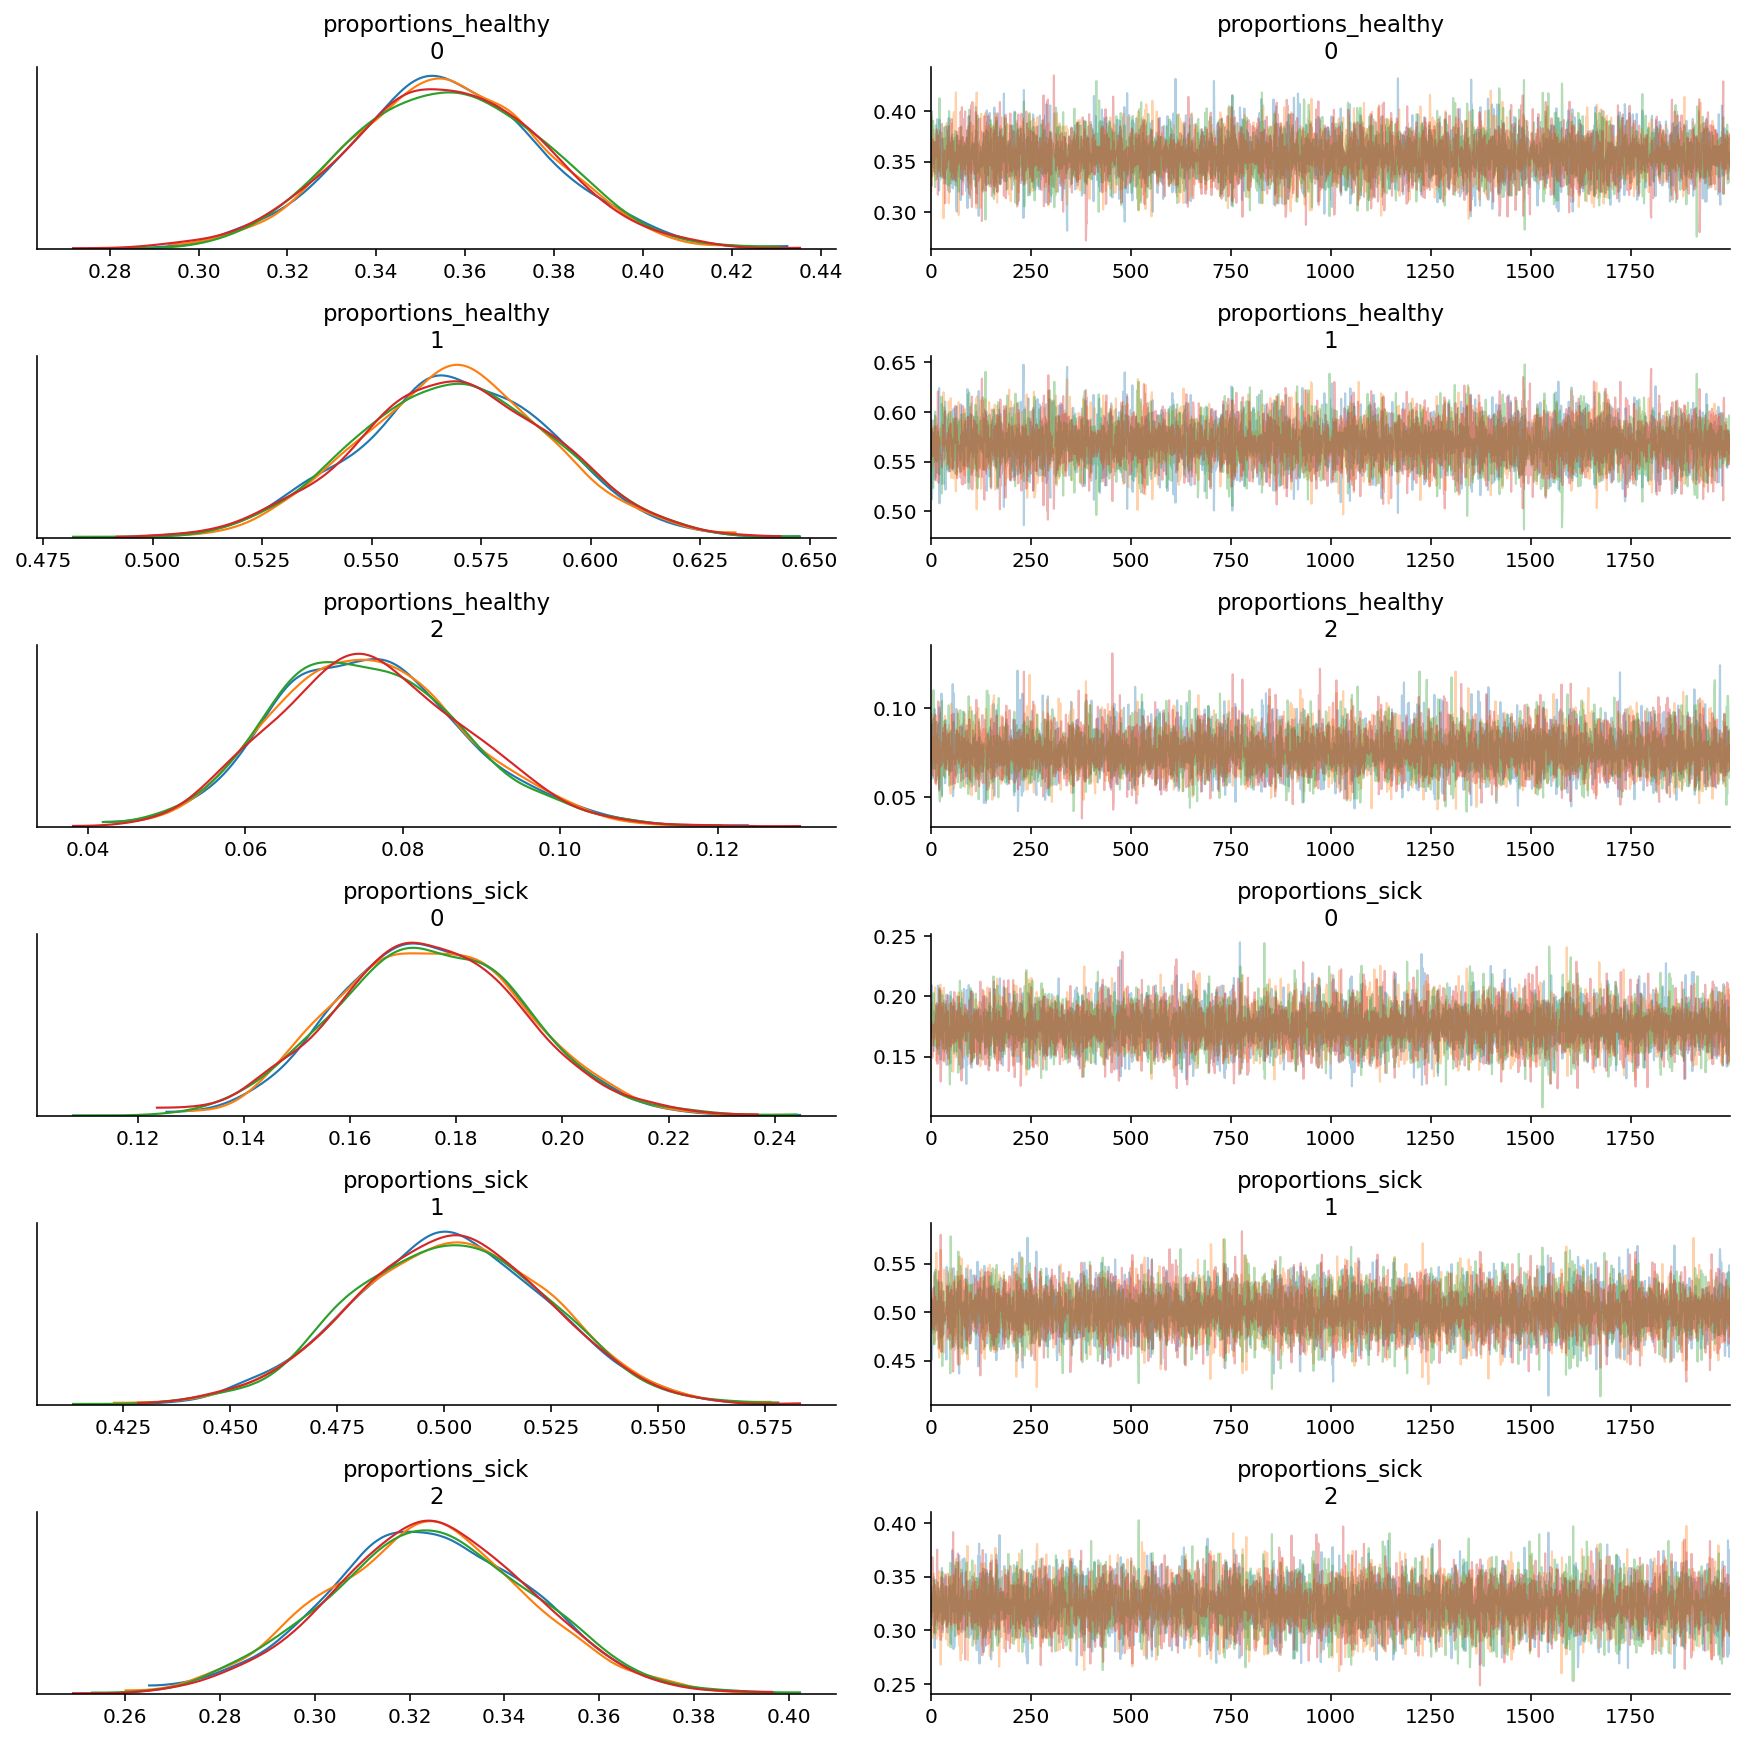

In [9]:
import arviz as az

with dirichlet_model:
    dirichlet_trace = pm.sample(2000)
    az.plot_trace(dirichlet_trace)

# Results

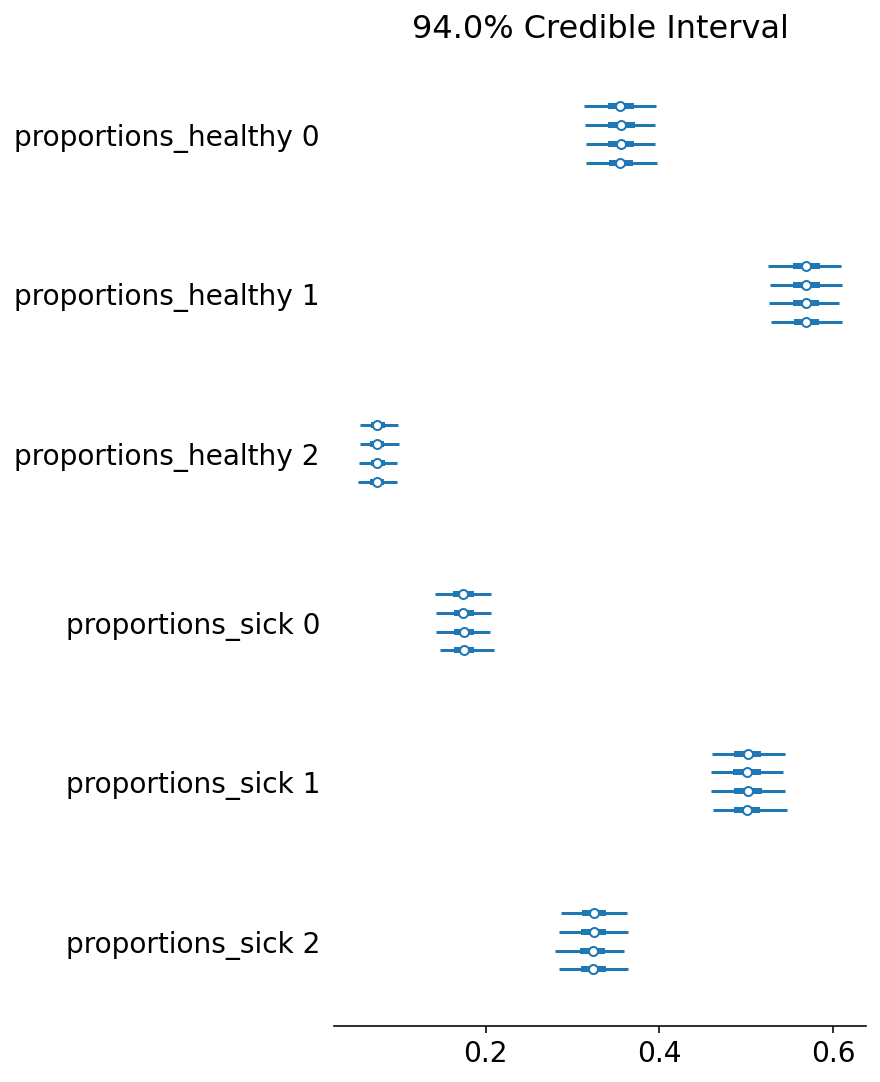

In [10]:
ylabels=[
    "healthy_bacteria1", "healthy_bacteria2", "healthy_bacteria3",
    "sick_bacteria1", "sick_bacteria2", "sick_bacteria3",
]
axes = az.plot_forest(dirichlet_trace)

In [11]:
healthy_proportions, sick_proportions

(array([0.35714286, 0.57142857, 0.07142857]),
 array([0.19230769, 0.51923077, 0.28846154]))

They match up with the original synthetic percentages!